In [1]:
#!pip install mip
from gurobipy import *
import numpy as np
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, poisson
import math
from itertools import product
from mip import Model, BINARY
import matplotlib.patches as mpatches



# Pregunta 1a

In [6]:
p1 = 150  
p2 = 70  
media_demanda_alta = 40
varianza_demanda_alta = 10
std_demanda_alta = np.sqrt(varianza_demanda_alta)
num_habitaciones = 100
N = 2000 

q = 1 - (p2 / p1)

#obtenemos la cantidad promedio usando dist. normal 
y1_optimo = norm.ppf(q, loc=media_demanda_alta, scale=std_demanda_alta)
y1_optimo = math.ceil(y1_optimo)


ingreso_total = []
vendidas_tarifa_alta = []
vendidas_tarifa_baja = []
overstock_tarifa_alta = []
understock_tarifa_alta = []

#simulamos 
for i in range(N):
    demanda_alta = np.random.normal(media_demanda_alta, std_demanda_alta)

    demanda_alta = max(0, min(demanda_alta, num_habitaciones))
    
    vendidas_alta = min(demanda_alta, y1_optimo)
    vendidas_baja = num_habitaciones - vendidas_alta
    
    ingreso = vendidas_alta * p1 + vendidas_baja * p2
    
    overstock = max(0, y1_optimo - demanda_alta)
    understock = max(0, demanda_alta - y1_optimo)
    
    ingreso_total.append(ingreso)
    vendidas_tarifa_alta.append(vendidas_alta)
    vendidas_tarifa_baja.append(vendidas_baja)
    overstock_tarifa_alta.append(overstock)
    understock_tarifa_alta.append(understock)

#obtenemos los promedios 
promedio_ingreso_total = np.mean(ingreso_total)
promedio_vendidas_tarifa_alta = np.mean(vendidas_tarifa_alta)
promedio_vendidas_tarifa_baja = np.mean(vendidas_tarifa_baja)
promedio_overstock = np.mean(overstock_tarifa_alta)
promedio_understock = np.mean(understock_tarifa_alta)

print(f"Cantidad promedio demanda alta", y1_optimo)
print(f"Promedio de ingreso total:", promedio_ingreso_total)
print(f"Promedio de habitaciones vendidas con tarifa alta:", promedio_vendidas_tarifa_alta)
print(f"Promedio de habitaciones vendidas con tarifa baja:", promedio_vendidas_tarifa_baja)
print(f"Promedio de overstock tarifa alta:", promedio_overstock)
print(f"Promedio de understock tarifa alta:", promedio_understock)



Cantidad promedio demanda alta 41
Promedio de ingreso total: 10131.577456179708
Promedio de habitaciones vendidas con tarifa alta: 39.144718202246366
Promedio de habitaciones vendidas con tarifa baja: 60.855281797753634
Promedio de overstock tarifa alta: 1.8552817977536276
Promedio de understock tarifa alta: 0.8492933057683976


# Pregunta 1b

In [7]:
p1 = 150 
p2 = 70  
media_demanda_alta = 40
varianza_demanda_alta = 10
num_habitaciones = 100
N = 2000 

q = 1 - (p2 / p1)
# Obtenemos la cantidad promedio usando dist. poisson 
y1_optimo_b = poisson.ppf(q, mu=media_demanda_alta)
y1_optimo_b = math.ceil(y1_optimo_b)


ingreso_total_b = []
vendidas_tarifa_alta_b = []
vendidas_tarifa_baja_b = []
overstock_tarifa_alta_b = []
understock_tarifa_alta_b = []

# simulamos 
for i in range(N):
    demanda_alta_b = np.random.poisson(media_demanda_alta)
    
    demanda_alta_b = max(0, min(demanda_alta_b, num_habitaciones))
    
    vendidas_alta_b = min(demanda_alta_b, y1_optimo_b)
    vendidas_baja_b = num_habitaciones - vendidas_alta_b

    ingreso_b = vendidas_alta_b * p1 + vendidas_baja_b * p2
    
    overstock_b = max(0, y1_optimo_b - demanda_alta_b)
    understock_b = max(0, demanda_alta_b - y1_optimo_b)
    
    ingreso_total_b.append(ingreso_b)
    vendidas_tarifa_alta_b.append(vendidas_alta_b)
    vendidas_tarifa_baja_b.append(vendidas_baja_b)
    overstock_tarifa_alta_b.append(overstock_b)
    understock_tarifa_alta_b.append(understock_b)

#obtenemos los promedios
promedio_ingreso_total_b = np.mean(ingreso_total_b)
promedio_vendidas_tarifa_alta_b = np.mean(vendidas_tarifa_alta_b)
promedio_vendidas_tarifa_baja_b = np.mean(vendidas_tarifa_baja_b)
promedio_overstock_b = np.mean(overstock_tarifa_alta_b)
promedio_understock_b = np.mean(understock_tarifa_alta_b)

print(f"Cantidad promedio demanda alta", y1_optimo_b)
print(f"Promedio de ingreso total:", promedio_ingreso_total_b)
print(f"Promedio de habitaciones vendidas con tarifa alta:", promedio_vendidas_tarifa_alta_b)
print(f"Promedio de habitaciones vendidas con tarifa baja:", promedio_vendidas_tarifa_baja_b)
print(f"Promedio de overstock tarifa alta:", promedio_overstock_b)
print(f"Promedio de understock tarifa alta:", promedio_understock_b)


Cantidad promedio demanda alta 40
Promedio de ingreso total: 9995.8
Promedio de habitaciones vendidas con tarifa alta: 37.4475
Promedio de habitaciones vendidas con tarifa baja: 62.5525
Promedio de overstock tarifa alta: 2.5525
Promedio de understock tarifa alta: 2.579


## Pregunta 2a ##

In [6]:

# Definimos la función EMSR-B que recibe los parámetros especificados.
def EMSR_B(C, q, mu, var):
    """
    EMSR-B calcula la cantidad de asientos que se deben reservar para cada tarifa
    teniendo en cuenta que la demanda sigue una distribución normal y priorizando
    las tarifas más caras.
    
    Parámetros:
    - C (int): Capacidad total de asientos.
    - q (list): Lista de precios de tarifas en orden descendente.
    - mu (list): Lista de demandas esperadas para cada tarifa.
    - var (list): Lista de varianzas para cada tarifa.
    
    Retorna:
    - R (list): Lista de asientos reservados para cada tarifa.
    """
    n = len(q)  # Número de niveles tarifarios
    B = np.zeros(n)  # arreglo de reservas
    Cap_max = np.zeros(n)
    R = np.zeros(n)
    
    # Iteración sobre cada tarifa (excepto la última, que toma el resto de los asientos)
    for i in range(n - 1):
        # Ponderamos la tarifa considerando desde la tarifa actual hasta la más cara
        f_barra = np.sum([q[j] * mu[j] for j in range(i + 1)]) / np.sum([mu[j] for j in range(i + 1)])
        
        # Desviación estándar de la demanda
        sigma = np.sqrt(np.sum([var[j] for j in range(i + 1)]))
        
        # Calculamos la probabilidad Z en función de las tarifas actuales y futuras
        P = max(0, min(1, (f_barra - q[i + 1]) / f_barra))
        
        # Calculamos el percentil de la normal para el nivel de reservas
        B_i = norm.ppf(P) * sigma + np.sum(mu[:i + 1])
        
        # Aseguramos que el número de asientos reservados no sea negativo
        B[i] = math.ceil((max(0, B_i)))

    B[-1] = C

    for i in range(n-1, 0, -1):
        Cap_max[i] = C- R[i-1]
        R[i] = B[i]-B[i-1]
    
 
    # El último grupo de tarifas recibe el resto de los asientos disponibles
    R[0]=B[0]
    Cap_max[0] = C
    
    return B , Cap_max, R


C = 120  # Capacidad total 
tarifas = ['E', 'G', 'D', 'F']  # tarifas
prices = [80, 70, 50, 40]  # Precios de las tarifas en orden de la más cara a la más barata
mu = [20, 30, 50, 3000]  # Demandas esperadas para cada tarifa (input, aleatorio)
var = [20, 30, 50, 3000]  # Varianzas de la demanda para cada tarifa (input, aleatorio)

# Llamamos a la función EMSR_B para calcular las reservas
Bi, capacidad, Ri = EMSR_B(C, prices, mu, var)

# Redondeamos los resultados

# Crear DataFrame con los resultados
df_reservas = pd.DataFrame({
    'Tarifa': tarifas,
    'Precio': prices,
    'Media': mu,
    'Varianza': var,
    'Protección anidada (Bi)': Bi,
    'Capacidad por tarifa': Ri,
    #'Capacidad acumulada': capacidad
})

# Mostrar el DataFrame
display(df_reservas)

,Tarifa,Precio,Media,Varianza,Protección anidada (Bi),Capacidad por tarifa
0,E,80,20,20,15.0,15.0
1,G,70,30,30,47.0,32.0
2,D,50,50,50,97.0,50.0
3,F,40,3000,3000,120.0,23.0


## Pregunta 2b ##

In [7]:

archivo = 'TrainData.csv'  # El archivo debe tener columnas llamadas D, E, G, F
datos_demanda = pd.read_csv(archivo)

# Ajustar una distribución normal para cada tarifa
# Calcular la media (mu) y desviación estándar (sigma) de la demanda para los últimos 500 periodos
mu_D = np.mean(datos_demanda['Fare_D'][-500:])  # Media para la tarifa D
sigma_D = np.std(datos_demanda['Fare_D'][-500:], ddof=1)  # Desviación estándar para la tarifa D

mu_E = np.mean(datos_demanda['Fare_E'][-500:])  # Media para la tarifa E
sigma_E = np.std(datos_demanda['Fare_E'][-500:], ddof=1)  # Desviación estándar para la tarifa E

mu_G = np.mean(datos_demanda['Fare_G'][-500:])  # Media para la tarifa G
sigma_G = np.std(datos_demanda['Fare_G'][-500:], ddof=1)  # Desviación estándar para la tarifa G

mu_F = np.mean(datos_demanda['Fare_F'][-500:])  # Media para la tarifa F
sigma_F = np.std(datos_demanda['Fare_F'][-500:], ddof=1)  # Desviación estándar para la tarifa F

#Crear las listas de medias (mu) y varianzas (var)
mu = [mu_E, mu_G, mu_D, mu_F]  # Medias de las demandas
var = [sigma_E**2, sigma_G**2, sigma_D**2, sigma_F**2]  # Varianzas (desviación estándar al cuadrado)

# Precios de las tarifas
prices = [80, 70, 50, 40]  # Precios en orden de la tarifa más cara a la más barata

# Capacidad total
C = 120

#Aplicar la función EMSR_B para determinar las reservas de asientos
Bi, capacidad, Ri = EMSR_B(C, prices, mu, var)

# Redondeamos los resultados

# Crear DataFrame con los resultados
df_train = pd.DataFrame({
    'Tarifa': tarifas,
    'Precio': prices,
    'Media': mu,
    'Varianza': var,
    'Protección anidada (Bi)': Bi,
    'Capacidad por tarifa': Ri,
    #'Capacidad acumulada': capacidad
})

# Mostrar el DataFrame
display(df_train)

,Tarifa,Precio,Media,Varianza,Protección anidada (Bi),Capacidad por tarifa
0,E,80,29.702,62.361920,21.0,21.0
1,G,70,39.694,151.755876,63.0,42.0
2,D,50,49.586,104.062729,114.0,51.0
3,F,40,69.480,239.015631,120.0,6.0


In [8]:
test = pd.read_csv("TestData.csv")

columnas_ordenadas = ['Fare_E', 'Fare_G', 'Fare_D', 'Fare_F']

test = test[columnas_ordenadas]



display(test)
display(test.describe())

,Fare_E,Fare_G,Fare_D,Fare_F
0,30,34,58,56
1,44,49,53,62
2,30,49,46,92
3,25,41,37,88
4,23,51,38,80
...,...,...,...,...
495,40,33,58,74
496,39,40,60,86
497,31,52,42,84
498,32,51,45,50


,Fare_E,Fare_G,Fare_D,Fare_F
count,500.000000,500.000000,500.000000,500.000000
mean,29.942000,40.150000,50.010000,68.940000
std,8.114081,11.536797,10.356467,14.727328
min,7.000000,6.000000,20.000000,25.000000
25%,24.750000,32.000000,43.000000,58.000000
50%,30.000000,40.000000,50.000000,69.000000
75%,35.000000,48.000000,57.000000,79.000000
max,53.000000,74.000000,80.000000,107.000000


In [9]:
num_tarifas = len(df_train)

#Calculamos el mínimo entre demanda y capacidad
pasajes_vendidos = test.clip(upper=df_train['Capacidad por tarifa'].values)
display(pasajes_vendidos)

#Calculamos los ingresos reales por periodos
pasajes_vendidos['Ingresos'] = sum(
    pasajes_vendidos.iloc[:, i] * prices[i] for i in range(num_tarifas)
)

display(pasajes_vendidos)

media_ing = pasajes_vendidos['Ingresos'].mean()
display(media_ing)

,Fare_E,Fare_G,Fare_D,Fare_F
0,21,34,51,6
1,21,42,51,6
2,21,42,46,6
3,21,41,37,6
4,21,42,38,6
...,...,...,...,...
495,21,33,51,6
496,21,40,51,6
497,21,42,42,6
498,21,42,45,6


,Fare_E,Fare_G,Fare_D,Fare_F,Ingresos
0,21,34,51,6,6850
1,21,42,51,6,7410
2,21,42,46,6,7160
3,21,41,37,6,6640
4,21,42,38,6,6760
...,...,...,...,...,...
495,21,33,51,6,6780
496,21,40,51,6,7270
497,21,42,42,6,6960
498,21,42,45,6,7110


np.float64(6743.24)

In [10]:
#display(prices)
df_train['Ingreso esperado'] = df_train['Capacidad por tarifa'] * prices
ingreso_totalesp = df_train['Ingreso esperado'].sum()
print(f'Ingreso esperado por EMSR-b: ${ingreso_totalesp}')
print(f'Promedio de ingreso real (test): ${media_ing}')

ingreso_totalesp-media_ing

Ingreso esperado por EMSR-b: $7410.0
Promedio de ingreso real (test): $6743.24


np.float64(666.7600000000002)

Podemos ver que, sobre todo en la tarifa más baja "F", hay muchos clientes que quedan sin comprar, pues la capacidad de la clase es de 6, mientras que la demanda media de esa tarifa en Test es de 69 clientes. 
Al comparar el ingreso esperado con el ingreso medio real, notamos que este último es menor. Esto quiere decir que perdemos aproxímadamente un promedio de $667 por un exceso de capacidad en las tarifas.
Así podemos ver que con el modelo EMSR-b perdemos tanto por clientes que no pudieron comprar (capacidad muy baja), como por asientos vacíos (capacidad muy alta); sin embargo, el modelo intenta ponderar el valor de cada tarifa con sus medidas estadísticas, maximizando los ingresos al garantizar que no se venden demasiados asientos a precios bajos cuando aún hay demanda potencial de tarifas más altas. Es por esto que se entrega una demanda baja a F, ya que se prioriza la demanda potencial de tarifas más altas.

## Pregunta 3

In [11]:
capacidad = 200
precio_boleto = 475
media_noshow = 30
std_noshow = 15
compensacion = 800

c_u = 475
c_o = 800
F_Y = c_u/(c_u + c_o)
Y = norm.ppf(F_Y, loc=media_noshow, scale=std_noshow)
Y = math.ceil(Y)

print(f'Se deberían aceptar {Y} reservas adicionales, teniendo una nueva capacidad total de {capacidad + Y} boletos')

Se deberían aceptar 26 reservas adicionales, teniendo una nueva capacidad total de 226 boletos


In [12]:
Y = 20
Y_comp = Y - 1 # si 19 personas o menos no se presentan, tendré gente que no podrá subirse al avión
z = (Y-media_noshow)/std_noshow
F_z = norm.cdf(z)
print(f'La probabilidad de que se tenga que compensar pasajeros es de {F_z*100}%')

La probabilidad de que se tenga que compensar pasajeros es de 25.24925375469229%


# Pregunta 4

$$ Minimizar \quad C_{máx} $$
### Sugeto a:
#### Relación entre tiempos de inicio y finalización 
$$ C_{ij}=S_{ij}+p_{ij}, \quad ∀i,j $$
#### Secuencia entre máquinas para cada trabajo
$$ S_{i(j+1)} \ge C_{ij}, \quad ∀ij,<M $$
#### Restricciones de no solapamiento entre trabajos en la misma máquina
$$ S_{kj} \ge C_{ij}-L*(1-X_{ikj}, \quad ∀i,k,j, \quad i \ne k) \quad \text{(Si el trabajo i precede al trabajo k en la máquina j)} $$
$$ S_{ij} \ge C_{kj} -L*X_{ikj}, \quad ∀i.k.j, \quad i\ne k \quad \text{(Si el trabajo k precede al trabajo i en la máquina j)} $$
#### Definimos C máximo como el máximo tiempo de finalización
$$ C_{máx} \ge C_{iM}, \quad ∀i $$

### Donde
$$ p_{ij} \quad \text{es el tiempo de procesamiento del trabajo } i \text{ en la máquina } j $$
$$ M \quad \text{es la cantidad de máquinas} $$
$$ N \quad \text{es la cantidad de trabajos} $$


### Variables de decisión 
$$ S_{ij} \quad \text {Tiempo de inicio del trabajo } i \text{ en la máquina } j $$
$$ C_{ij} \quad \text {Tiempo de finalización del trabajo } i \text{ en la máquina } j $$
$$ C_{máx} \quad \text {Makespan} $$
$$ X_{ikj} \quad \text {Variable binaria que determina el orden entre dos trabajos,} \quad
X_{ikj} = 
\begin{cases}
1 & \text{El trabajo } i \text { se realiza antes que el trabajo } k \text { en la máquina } j \\
0 & \text{El trabajo } k \text { se realiza antes que el trabajo } i \text { en la máquina } j \end{cases} $$

In [29]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

N = 10  # Número de trabajos
M = 3  # Número de máquinas

# Tiempos de procesamiento para cada trabajo en cada máquina
p_ij = [
    [5, 3, 9], 
    [6, 1, 6], 
    [8, 3, 8], 
    [8, 2, 7], 
    [2, 4, 6], 
    [7, 2, 9], 
    [10, 2, 8],
    [5, 3, 4], 
    [1, 4, 6], 
    [1, 2, 4], 
]


model = gp.Model("FlowShopScheduling")

# Variables de decisión: tiempo de inicio S[i,j] y tiempo de finalización C[i,j]
S = model.addVars(N, M, vtype=GRB.INTEGER, name="Start")
C = model.addVars(N, M, vtype=GRB.INTEGER, name="Completion")

# Variable makespan a minimizar
makespan = model.addVar(vtype=GRB.CONTINUOUS, name="makespan")

# Restricciones: Cálculo del tiempo de finalización para cada trabajo en cada máquina
for i in range(N):
    for j in range(M):
        model.addConstr(C[i, j] == S[i, j] + p_ij[i][j])

# Restricciones de secuencia entre máquinas para cada trabajo
for i in range(N):
    for j in range(M - 1):
        model.addConstr(S[i, j + 1] >= C[i, j])

# Variables binarias para decidir el orden de los trabajos en cada máquina
X = model.addVars(N, N, M, vtype=GRB.BINARY, name="X")

# Gran valor L para modelar el orden (puede ser el makespan máximo teórico)
L = 1000

# Restricciones de no solapamiento entre trabajos en la misma máquina
for j in range(M):
    for i in range(N):
        for k in range(i + 1, N):
            # Si X[i,k,j] = 1, entonces el trabajo i debe terminar antes que comience k
            model.addConstr(S[k, j] >= C[i, j] - L * (1 - X[i, k, j]))
            # Si X[i,k,j] = 0, entonces el trabajo k debe terminar antes que comience i
            model.addConstr(S[i, j] >= C[k, j] - L * X[i, k, j])

# Restricción del makespan: debe ser mayor o igual al tiempo de finalización en la última máquina
for i in range(N):
    model.addConstr(makespan >= C[i, M - 1])


model.setObjective(makespan, GRB.MINIMIZE)


model.optimize()


if model.status == GRB.OPTIMAL:
    print(f"Tiempo mínimo de finalización (makespan): {makespan.X}")
    
    for j in range(M):
        print(f"\nMáquina {j+1}:")
        # Crear una lista con los tiempos de inicio para cada trabajo en la máquina j
        inicio_trabajos = [(i+1, S[i, j].X) for i in range(N)]
        # Ordenar los trabajos por el tiempo de inicio
        inicio_trabajos.sort(key=lambda x: x[1])
        
        print("Orden de trabajos (Trabajo, Tiempo de inicio):")
        for trabajo, inicio in inicio_trabajos:
            print(f"Trabajo {trabajo}: Inicio = {inicio:.2f}, Fin = {C[trabajo-1, j].X:.2f}")

inicio_trabajos = pd.DataFrame(inicio_trabajos, columns=['Trabajo', 'Tiempo de inicio'])
print(inicio_trabajos)



Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 330 rows, 361 columns and 930 nonzeros
Model fingerprint: 0xe0f9660f
Variable types: 1 continuous, 360 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 30 rows and 195 columns


Presolve time: 0.00s
Presolved: 300 rows, 166 columns, 870 nonzeros
Variable types: 0 continuous, 166 integer (135 binary)
Found heuristic solution: objective 72.0000000

Root relaxation: objective 2.000000e+01, 106 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   20.00000    0   77   72.00000   20.00000  72.2%     -    0s
     0     0   28.00000    0   48   72.00000   28.00000  61.1%     -    0s
H    0     0                      71.0000000   28.00000  60.6%     -    0s
     0     0   36.61633    0   95   71.00000   36.61633  48.4%     -    0s
H    0     0                      70.0000000   36.97878  47.2%     -    0s
     0     0   38.16900    0   89   70.00000   38.16900  45.5%     -    0s
     0     0   38.16900    0   89   70.00000   38.16900  45.5%     -    0s
     0     0   42.00407    0   92   70.00000   42.00407  40.0%  

In [25]:
def graficar_gantt(tiempos_procesamiento, num_maquinas, num_tareas):
    """
    Argumentos:
    tiempos_procesamiento : Lista de listas donde las filas son tareas y las columnas son máquinas, contiene el tiempo de procesamiento de la tarea i en la máquina j.
    num_maquinas; Número total de máquinas
    num_tareas; Número total de tareas
    """
    tiempos_inicio = [[] for _ in range(num_maquinas)] # hacemos una matriz que entrega por máquina, cuál es el tiempo de inicio de cada tarea
    for j in range(num_tareas): 
        for i in range(num_maquinas):
            tiempos_inicio[i].append(S[j,i].X)

    fig, ax = plt.subplots(figsize=(10, 6))

    colores = plt.cm.get_cmap('tab20', num_tareas)
    
    # Recorrer cada máquina y mostrar las tareas asignadas en el tiempo
    for maquina in range(num_maquinas):
        for tarea in range(num_tareas):
            inicio_tarea = tiempos_inicio[maquina][tarea]
            duracion_tarea = tiempos_procesamiento[tarea][maquina]
            
            if duracion_tarea > 0:  # Evitamos errores si la tarea no tiene duración
                ax.barh(maquina, duracion_tarea, left=inicio_tarea, color=colores(tarea), edgecolor='black')
                #etiqueta
                ax.text(inicio_tarea + duracion_tarea / 2, maquina, f"T{tarea+1}", 
                        ha='center', va='center', color='white', fontsize=10)
    
    ax.set_xlabel('Tiempo (UT)')
    ax.set_ylabel('Máquinas')
    ax.set_yticks(range(num_maquinas))
    ax.set_yticklabels([f"M{m+1}" for m in range(num_maquinas)])
    ax.set_title('Diagrama de Gantt - Tareas por Máquina')
    
    plt.tight_layout()
    plt.show()

C:\Users\mrive\AppData\Local\Temp\ipykernel_23560\4200940514.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores = plt.cm.get_cmap('tab20', num_tareas)


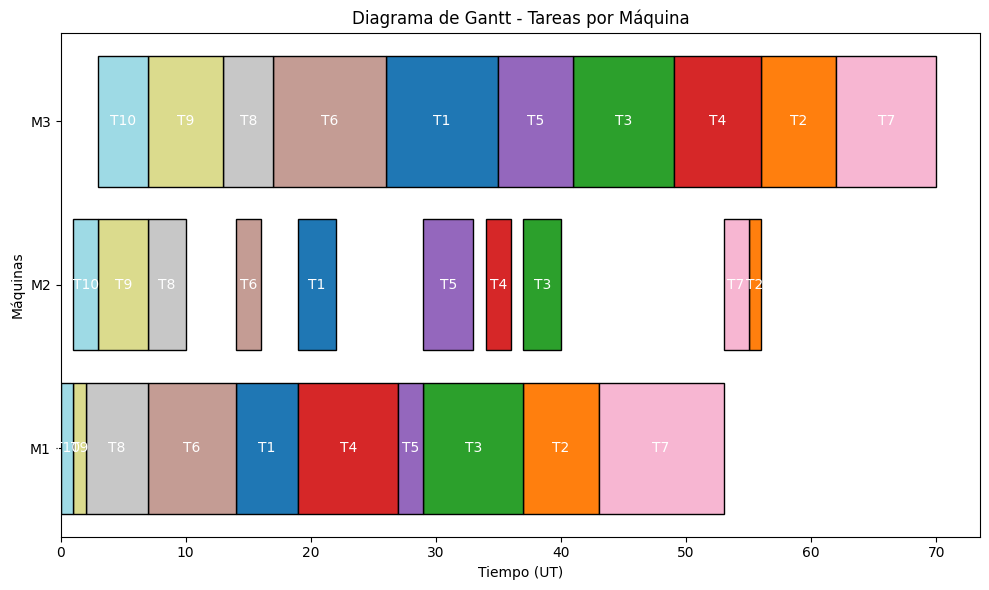

In [26]:
graficar_gantt(p_ij,M,N)

## Pregunta 5

$$ p_{ij} \quad \text{es el tiempo de procesamiento del trabajo } i \text{ en la máquina } j $$
$$ M \quad \text{es la cantidad de máquinas} $$
$$ J \quad \text{es la cantidad de trabajos} $$
$$ o_{r}^j \quad \text{es proceso en posición } r \text{ del trabajo } j $$
$$ O^j = (o_1^j , o_2^j , ... ) \quad \text{es el orden de procesamiento del trabajo } j $$

### Variables de decisión:
$$ x_{ij} \quad \text{es el tiempo de comienzo del trabajo } j \text{ en la máquina } y $$
$$ y_{ij} \quad \text{es 1 si el trabajo } j \text{precede al trabajo } k \text{en la máquina } i \text{, y 0 si no} $$
$$ C \quad \text{es el Makespan }$$

In [14]:
M = 5 #columnas
J = 8 #filas

p_ij = np.array([[50, 90, 30, 60, 40],
        [65, 35, 75, 50, 45],
        [80, 60, 25, 70, 55],
        [55, 40, 45, 65, 30],
        [45, 85, 60, 35, 90],
        [40, 70, 85, 35, 55],
        [65, 40, 50, 75, 30],
        [55, 45, 80, 60, 65]])

Mgrande = sum(p_ij[i][j] for i in range(J) for j in range(M))

O_j = np.array([[3, 1, 4, 5, 2],
       [2, 3, 5, 1, 4],
       [5, 2, 4, 1, 3],
       [1, 4, 3, 2, 5],
       [4, 3, 5, 2, 1],
       [3, 5, 1, 4, 2],
       [1, 3, 5, 2, 4],
       [2, 5, 3, 4, 1]])

O_jm = O_j - 1 #para que las máquinas vayan de 0 a 4

model = Model('JSSP')

c = model.add_var(name="C")

x = [[model.add_var(name='x({},{})'.format(j+1, i+1))
      for i in range(M)] for j in range(J)]

y = [[[model.add_var(var_type=BINARY, name='y({},{},{})'.format(j+1, k+1, i+1))
       for i in range(M)] for k in range(J)] for j in range(J)]

model.objective = c

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-12


In [15]:
for (j, i) in product(range(J), range(1, M)):    #tiempo de comienzo = el tiempo de comienzo anterior + tiempo de procesamiento anterior
    model += x[j][O_jm[j][i]] - x[j][O_jm[j][i-1]] >= \
        p_ij[j][O_jm[j][i-1]]

for (j, k) in product(range(J), range(J)):
    if k != j:
        for i in range(M):
            model += x[j][i] - x[k][i] + Mgrande*y[j][k][i] >= p_ij[k][i]
            model += -x[j][i] + x[k][i] - Mgrande*y[j][k][i] >= p_ij[j][i] - Mgrande  #consistencia entre tiempo y orden (un trabajo se debe realizar antes que otro)

for j in range(J):
    model += c - x[j][O_jm[j][M - 1]] >= p_ij[j][O_jm[j][M - 1]] #consistencia makespan

model.optimize()

Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[rosetta2] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 600 rows, 361 columns and 1760 nonzeros
Model fingerprint: 0xfe5e866d
Variable types: 41 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+03]
Presolve removed 0 rows and 40 columns
Presolve time: 0.00s
Presolved: 600 rows, 321 columns, 1760 nonzeros
Variable types: 41 continuous, 280 integer (280 binary)
Found heuristic solution: objective 1900.0000000

Root relaxation: objective 3.150000e+02, 97 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |    

<OptimizationStatus.OPTIMAL: 0>

Thread count was 8 (of 8 available processors)

Solution count 10: 540 540 545 ... 605

Optimal solution found (tolerance 1.00e-04)
Best objective 5.399999999459e+02, best bound 5.399999999459e+02, gap 0.0000%


In [16]:
print("Makespan: ", c.x)
for (j, i) in product(range(J), range(M)):
    print("el trabajo %d empieza en la máquina %d al tiempo %g " % (j+1, i+1, x[j][i].x))


Makespan:  539.9999999458989
el trabajo 1 empieza en la máquina 1 al tiempo 55 
el trabajo 1 empieza en la máquina 2 al tiempo 215 
el trabajo 1 empieza en la máquina 3 al tiempo 0 
el trabajo 1 empieza en la máquina 4 al tiempo 105 
el trabajo 1 empieza en la máquina 5 al tiempo 175 
el trabajo 2 empieza en la máquina 1 al tiempo 425 
el trabajo 2 empieza en la máquina 2 al tiempo 175 
el trabajo 2 empieza en la máquina 3 al tiempo 305 
el trabajo 2 empieza en la máquina 4 al tiempo 490 
el trabajo 2 empieza en la máquina 5 al tiempo 380 
el trabajo 3 empieza en la máquina 1 al tiempo 290 
el trabajo 3 empieza en la máquina 2 al tiempo 115 
el trabajo 3 empieza en la máquina 3 al tiempo 515 
el trabajo 3 empieza en la máquina 4 al tiempo 175 
el trabajo 3 empieza en la máquina 5 al tiempo 0 
el trabajo 4 empieza en la máquina 1 al tiempo 175 
el trabajo 4 empieza en la máquina 2 al tiempo 430 
el trabajo 4 empieza en la máquina 3 al tiempo 380 
el trabajo 4 empieza en la máquina 4 al 

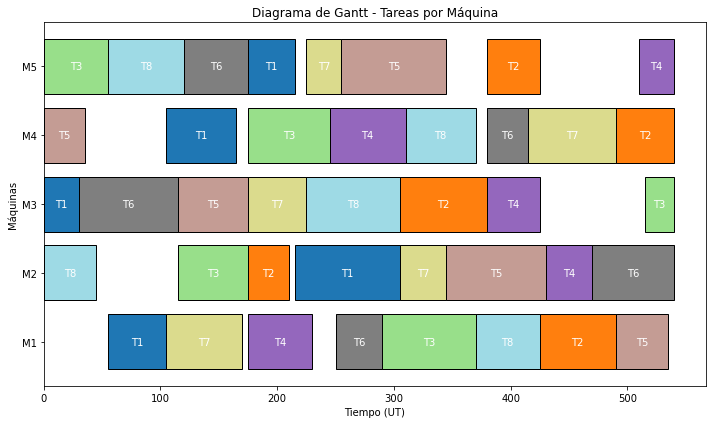

In [17]:
def graficar_gantt(tiempos_procesamiento, num_maquinas, num_tareas):
    """
    Argumentos:
    tiempos_procesamiento : Lista de listas donde las filas son tareas y las columnas son máquinas, contiene el tiempo de procesamiento de la tarea i en la máquina j.
    num_maquinas; Número total de máquinas
    num_tareas; Número total de tareas
    """
    tiempos_inicio = [[] for _ in range(num_maquinas)] # hacemos una matriz que entrega por máquina, cuál es el tiempo de inicio de cada tarea
    for j in range(num_tareas): 
        for i in range(num_maquinas):
            tiempos_inicio[i].append(x[j][i].x)

    fig, ax = plt.subplots(figsize=(10, 6))

    colores = plt.cm.get_cmap('tab20', num_tareas)
    
    # Recorrer cada máquina y mostrar las tareas asignadas en el tiempo
    for maquina in range(num_maquinas):
        for tarea in range(num_tareas):
            inicio_tarea = tiempos_inicio[maquina][tarea]
            duracion_tarea = tiempos_procesamiento[tarea][maquina]
            
            if duracion_tarea > 0:  # Evitamos errores si la tarea no tiene duración
                ax.barh(maquina, duracion_tarea, left=inicio_tarea, color=colores(tarea), edgecolor='black')
                #etiqueta
                ax.text(inicio_tarea + duracion_tarea / 2, maquina, f"T{tarea+1}", 
                        ha='center', va='center', color='white', fontsize=10)
    
    ax.set_xlabel('Tiempo (UT)')
    ax.set_ylabel('Máquinas')
    ax.set_yticks(range(num_maquinas))
    ax.set_yticklabels([f"M{m+1}" for m in range(num_maquinas)])
    ax.set_title('Diagrama de Gantt - Tareas por Máquina')
    
    plt.tight_layout()
    plt.show()

graficar_gantt(p_ij, M, J)